In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical


**TSP Environment**

In [ ]:

class TSPEnvironment:
    def __init__(self, num_customers=20):
        self.num_customers = num_customers
        self.reset()

    def reset(self):
        self.customers = np.random.rand(self.num_customers, 2) * 100
        self.depot = np.random.rand(1, 2) * 100
        self.demand = np.random.randint(1, 10, size=self.num_customers)
        self.visited = set()
        self.current_idx = np.random.randint(0, self.num_customers)
        self.visited.add(self.current_idx)
        self.total_distance = 0.0
        self.available = set(range(self.num_customers)) - self.visited
        return self.get_state()

    def get_state(self):
        cust_xy = self.customers[self.current_idx] / 100.0
        depot_xy = self.depot.flatten() / 100.0
        demand_val = self.demand[self.current_idx] / 10.0
        return np.concatenate([cust_xy, depot_xy, [demand_val]])

    def step(self, action):
        if action not in self.available:
            return self.get_state(), -100.0, False

        from_city = self.customers[self.current_idx]
        to_city = self.customers[action]
        dist = np.linalg.norm(from_city - to_city)

        self.total_distance += dist
        self.visited.add(action)
        self.current_idx = action
        self.available.remove(action)

        done = len(self.visited) == self.num_customers
        reward = -dist

        return self.get_state(), reward, done

    def get_total_distance(self):
        return self.total_distance


**ppo_model**

In [ ]:
class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)


class PPOAgent:
    def __init__(self, input_dim, hidden_dim, action_dim, lr=1e-3):
        self.actor = Actor(input_dim, hidden_dim, action_dim)
        self.critic = Critic(input_dim, hidden_dim)
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state, mask):
        state = torch.FloatTensor(state)
        logits = self.actor(state)
        masked_logits = logits.clone()
        masked_logits[~mask] = -1e9
        dist = Categorical(logits=masked_logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy()

    def evaluate(self, states):
        return self.critic(torch.FloatTensor(states))


**train**

In [ ]:

import torch
import numpy as np
from tqdm import trange
from torch.distributions import Categorical

# Use previously defined TSPEnvironment and PPOAgent in same notebook

# --- Hyperparameters ---
num_cust = 20
input_dim = 5  # x, y, depot_x, depot_y, demand
hidden_dim = 128
num_episodes = 10000

# --- Init ---
env = TSPEnvironment(num_customers=num_cust)
agent = PPOAgent(input_dim, hidden_dim, num_cust)

returns_log = []

# --- Training Loop ---
for episode in trange(num_episodes):
    state = env.reset()
    done = False
    states, actions, log_probs, rewards, masks = [], [], [], [], []

    while not done:
        mask = torch.zeros(num_cust, dtype=torch.bool)
        mask[list(env.available)] = 1
        action, log_prob, _ = agent.select_action(state, mask)

        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)

        state, reward, done = env.step(action)
        rewards.append(reward)
        masks.append(mask)

    # Compute discounted returns
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + 0.99 * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # Convert to tensors
    states_tensor = torch.tensor(states, dtype=torch.float32)
    actions_tensor = torch.tensor(actions)
    log_probs_tensor = torch.stack(log_probs)
    values = agent.evaluate(states_tensor).squeeze()
    advantage = returns - values.detach()

    # Actor loss
    logits = agent.actor(states_tensor)
    dists = Categorical(logits=logits)
    new_log_probs = dists.log_prob(actions_tensor)
    ratio = (new_log_probs - log_probs_tensor).exp()
    surr = ratio * advantage
    actor_loss = -surr.mean()

    # Critic loss
    critic_loss = (returns - values).pow(2).mean()

    # Backprop
    agent.optimizer_actor.zero_grad()
    actor_loss.backward()
    agent.optimizer_actor.step()

    agent.optimizer_critic.zero_grad()
    critic_loss.backward()
    agent.optimizer_critic.step()

    # Log training
    if episode % 100 == 0:
        total_dist = env.get_total_distance()
        returns_log.append(total_dist)
        print(f"Episode {episode} | Distance: {total_dist:.2f} | Actor Loss: {actor_loss.item():.4f}")


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipython-input-4-2433437926.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states_tensor = torch.tensor(states, dtype=torch.float32)
  0%|          | 5/10000 [00:00<07:07, 23.40it/s]

Episode 0 | Distance: 966.41 | Actor Loss: 0.2654


  1%|          | 106/10000 [00:03<03:47, 43.53it/s]

Episode 100 | Distance: 921.09 | Actor Loss: 0.2775


  2%|▏         | 206/10000 [00:05<03:47, 43.08it/s]

Episode 200 | Distance: 1104.43 | Actor Loss: 0.2827


  3%|▎         | 307/10000 [00:08<05:06, 31.65it/s]

Episode 300 | Distance: 882.18 | Actor Loss: 0.2424


  4%|▍         | 406/10000 [00:10<03:37, 44.08it/s]

Episode 400 | Distance: 904.81 | Actor Loss: 0.2598


  5%|▌         | 506/10000 [00:13<03:34, 44.24it/s]

Episode 500 | Distance: 978.22 | Actor Loss: 0.2656


  6%|▌         | 606/10000 [00:15<03:41, 42.49it/s]

Episode 600 | Distance: 1079.00 | Actor Loss: 0.2705


  7%|▋         | 706/10000 [00:17<03:34, 43.24it/s]

Episode 700 | Distance: 1039.01 | Actor Loss: 0.2712


  8%|▊         | 806/10000 [00:20<04:33, 33.62it/s]

Episode 800 | Distance: 966.57 | Actor Loss: 0.2784


  9%|▉         | 908/10000 [00:23<03:30, 43.25it/s]

Episode 900 | Distance: 841.24 | Actor Loss: 0.2705


 10%|█         | 1008/10000 [00:25<03:30, 42.78it/s]

Episode 1000 | Distance: 984.96 | Actor Loss: 0.2610


 11%|█         | 1108/10000 [00:27<03:24, 43.54it/s]

Episode 1100 | Distance: 973.75 | Actor Loss: 0.2758


 12%|█▏        | 1208/10000 [00:29<03:16, 44.70it/s]

Episode 1200 | Distance: 909.66 | Actor Loss: 0.2792


 13%|█▎        | 1306/10000 [00:32<04:15, 34.06it/s]

Episode 1300 | Distance: 1052.53 | Actor Loss: 0.2758


 14%|█▍        | 1408/10000 [00:35<03:18, 43.28it/s]

Episode 1400 | Distance: 1020.52 | Actor Loss: 0.2788


 15%|█▌        | 1508/10000 [00:37<03:16, 43.24it/s]

Episode 1500 | Distance: 800.29 | Actor Loss: 0.2809


 16%|█▌        | 1608/10000 [00:39<03:11, 43.87it/s]

Episode 1600 | Distance: 899.81 | Actor Loss: 0.2679


 17%|█▋        | 1708/10000 [00:42<03:08, 44.08it/s]

Episode 1700 | Distance: 1011.97 | Actor Loss: 0.2762


 18%|█▊        | 1805/10000 [00:44<03:53, 35.07it/s]

Episode 1800 | Distance: 1147.35 | Actor Loss: 0.2754


 19%|█▉        | 1908/10000 [00:47<03:10, 42.47it/s]

Episode 1900 | Distance: 809.74 | Actor Loss: 0.2687


 20%|██        | 2008/10000 [00:49<03:02, 43.86it/s]

Episode 2000 | Distance: 1133.16 | Actor Loss: 0.2726


 21%|██        | 2108/10000 [00:52<03:03, 42.89it/s]

Episode 2100 | Distance: 956.06 | Actor Loss: 0.2495


 22%|██▏       | 2208/10000 [00:54<03:08, 41.28it/s]

Episode 2200 | Distance: 950.66 | Actor Loss: 0.2526


 23%|██▎       | 2303/10000 [00:56<03:10, 40.32it/s]

Episode 2300 | Distance: 909.48 | Actor Loss: 0.2555


 24%|██▍       | 2408/10000 [00:59<03:04, 41.10it/s]

Episode 2400 | Distance: 797.84 | Actor Loss: 0.2618


 25%|██▌       | 2508/10000 [01:01<02:50, 43.83it/s]

Episode 2500 | Distance: 871.34 | Actor Loss: 0.2743


 26%|██▌       | 2608/10000 [01:04<02:47, 44.20it/s]

Episode 2600 | Distance: 1034.63 | Actor Loss: 0.2615


 27%|██▋       | 2708/10000 [01:06<02:47, 43.47it/s]

Episode 2700 | Distance: 1051.65 | Actor Loss: 0.2832


 28%|██▊       | 2808/10000 [01:08<02:43, 44.01it/s]

Episode 2800 | Distance: 984.45 | Actor Loss: 0.2639


 29%|██▉       | 2910/10000 [01:11<02:57, 40.05it/s]

Episode 2900 | Distance: 987.13 | Actor Loss: 0.2619


 30%|███       | 3005/10000 [01:13<02:33, 45.57it/s]

Episode 3000 | Distance: 907.98 | Actor Loss: 0.2759


 31%|███       | 3105/10000 [01:16<02:41, 42.61it/s]

Episode 3100 | Distance: 1098.10 | Actor Loss: 0.2759


 32%|███▏      | 3205/10000 [01:18<02:36, 43.55it/s]

Episode 3200 | Distance: 939.84 | Actor Loss: 0.2578


 33%|███▎      | 3310/10000 [01:20<02:30, 44.50it/s]

Episode 3300 | Distance: 1075.55 | Actor Loss: 0.2584


 34%|███▍      | 3404/10000 [01:23<03:41, 29.72it/s]

Episode 3400 | Distance: 1138.12 | Actor Loss: 0.2482


 35%|███▌      | 3509/10000 [01:26<02:27, 43.94it/s]

Episode 3500 | Distance: 961.03 | Actor Loss: 0.2601


 36%|███▌      | 3609/10000 [01:28<02:22, 44.96it/s]

Episode 3600 | Distance: 1119.65 | Actor Loss: 0.2656


 37%|███▋      | 3709/10000 [01:30<02:23, 43.84it/s]

Episode 3700 | Distance: 855.01 | Actor Loss: 0.2890


 38%|███▊      | 3809/10000 [01:33<02:22, 43.44it/s]

Episode 3800 | Distance: 933.73 | Actor Loss: 0.2631


 39%|███▉      | 3903/10000 [01:36<03:14, 31.43it/s]

Episode 3900 | Distance: 788.86 | Actor Loss: 0.2678


 40%|████      | 4010/10000 [01:38<02:15, 44.26it/s]

Episode 4000 | Distance: 824.40 | Actor Loss: 0.2440


 41%|████      | 4110/10000 [01:40<02:09, 45.34it/s]

Episode 4100 | Distance: 845.19 | Actor Loss: 0.2694


 42%|████▏     | 4210/10000 [01:43<02:07, 45.31it/s]

Episode 4200 | Distance: 799.08 | Actor Loss: 0.2598


 43%|████▎     | 4305/10000 [01:45<02:08, 44.22it/s]

Episode 4300 | Distance: 951.16 | Actor Loss: 0.2582


 44%|████▍     | 4405/10000 [01:47<02:38, 35.26it/s]

Episode 4400 | Distance: 1123.10 | Actor Loss: 0.2706


 45%|████▌     | 4509/10000 [01:51<02:09, 42.57it/s]

Episode 4500 | Distance: 1017.60 | Actor Loss: 0.2487


 46%|████▌     | 4609/10000 [01:53<02:03, 43.61it/s]

Episode 4600 | Distance: 894.32 | Actor Loss: 0.2497


 47%|████▋     | 4709/10000 [01:56<02:03, 43.01it/s]

Episode 4700 | Distance: 883.07 | Actor Loss: 0.2619


 48%|████▊     | 4809/10000 [01:58<02:00, 43.22it/s]

Episode 4800 | Distance: 973.95 | Actor Loss: 0.2649


 49%|████▉     | 4906/10000 [02:00<02:35, 32.71it/s]

Episode 4900 | Distance: 1225.30 | Actor Loss: 0.2762


 50%|█████     | 5010/10000 [02:03<01:52, 44.43it/s]

Episode 5000 | Distance: 831.08 | Actor Loss: 0.2729


 51%|█████     | 5110/10000 [02:05<01:51, 44.01it/s]

Episode 5100 | Distance: 950.06 | Actor Loss: 0.2703


 52%|█████▏    | 5210/10000 [02:08<01:44, 45.77it/s]

Episode 5200 | Distance: 1066.71 | Actor Loss: 0.2643


 53%|█████▎    | 5305/10000 [02:10<01:48, 43.15it/s]

Episode 5300 | Distance: 921.76 | Actor Loss: 0.2435


 54%|█████▍    | 5407/10000 [02:12<02:16, 33.59it/s]

Episode 5400 | Distance: 904.52 | Actor Loss: 0.2581


 55%|█████▌    | 5506/10000 [02:15<01:41, 44.28it/s]

Episode 5500 | Distance: 921.73 | Actor Loss: 0.2608


 56%|█████▌    | 5606/10000 [02:17<01:37, 45.20it/s]

Episode 5600 | Distance: 961.93 | Actor Loss: 0.2573


 57%|█████▋    | 5706/10000 [02:20<01:40, 42.83it/s]

Episode 5700 | Distance: 1121.55 | Actor Loss: 0.2681


 58%|█████▊    | 5806/10000 [02:22<01:36, 43.42it/s]

Episode 5800 | Distance: 811.94 | Actor Loss: 0.2511


 59%|█████▉    | 5904/10000 [02:24<02:03, 33.18it/s]

Episode 5900 | Distance: 964.65 | Actor Loss: 0.2606


 60%|██████    | 6007/10000 [02:27<01:33, 42.92it/s]

Episode 6000 | Distance: 961.82 | Actor Loss: 0.2701


 61%|██████    | 6107/10000 [02:29<01:27, 44.59it/s]

Episode 6100 | Distance: 849.17 | Actor Loss: 0.2579


 62%|██████▏   | 6207/10000 [02:32<01:25, 44.42it/s]

Episode 6200 | Distance: 734.56 | Actor Loss: 0.2708


 63%|██████▎   | 6307/10000 [02:34<01:24, 43.91it/s]

Episode 6300 | Distance: 1008.31 | Actor Loss: 0.2660


 64%|██████▍   | 6407/10000 [02:36<01:23, 43.17it/s]

Episode 6400 | Distance: 846.28 | Actor Loss: 0.2634


 65%|██████▌   | 6508/10000 [02:39<01:28, 39.60it/s]

Episode 6500 | Distance: 1012.44 | Actor Loss: 0.2696


 66%|██████▌   | 6608/10000 [02:42<01:19, 42.86it/s]

Episode 6600 | Distance: 1088.50 | Actor Loss: 0.2622


 67%|██████▋   | 6708/10000 [02:44<01:14, 44.06it/s]

Episode 6700 | Distance: 1023.63 | Actor Loss: 0.2610


 68%|██████▊   | 6808/10000 [02:46<01:11, 44.50it/s]

Episode 6800 | Distance: 773.87 | Actor Loss: 0.2570


 69%|██████▉   | 6908/10000 [02:48<01:08, 45.01it/s]

Episode 6900 | Distance: 1081.22 | Actor Loss: 0.2609


 70%|███████   | 7006/10000 [02:51<01:36, 30.93it/s]

Episode 7000 | Distance: 1053.57 | Actor Loss: 0.2694


 71%|███████   | 7109/10000 [02:54<01:04, 44.78it/s]

Episode 7100 | Distance: 900.62 | Actor Loss: 0.2576


 72%|███████▏  | 7209/10000 [02:56<01:02, 44.40it/s]

Episode 7200 | Distance: 913.57 | Actor Loss: 0.2675


 73%|███████▎  | 7309/10000 [02:58<01:02, 42.96it/s]

Episode 7300 | Distance: 924.06 | Actor Loss: 0.2647


 74%|███████▍  | 7409/10000 [03:00<00:57, 45.26it/s]

Episode 7400 | Distance: 913.97 | Actor Loss: 0.2670


 75%|███████▌  | 7506/10000 [03:03<01:12, 34.27it/s]

Episode 7500 | Distance: 1065.85 | Actor Loss: 0.2606


 76%|███████▌  | 7608/10000 [03:06<00:54, 43.87it/s]

Episode 7600 | Distance: 969.25 | Actor Loss: 0.2580


 77%|███████▋  | 7708/10000 [03:08<00:52, 43.81it/s]

Episode 7700 | Distance: 882.72 | Actor Loss: 0.2586


 78%|███████▊  | 7808/10000 [03:10<00:49, 43.85it/s]

Episode 7800 | Distance: 1080.60 | Actor Loss: 0.2637


 79%|███████▉  | 7908/10000 [03:13<00:45, 45.56it/s]

Episode 7900 | Distance: 1299.87 | Actor Loss: 0.2716


 80%|████████  | 8006/10000 [03:15<01:01, 32.68it/s]

Episode 8000 | Distance: 1045.14 | Actor Loss: 0.2640


 81%|████████  | 8109/10000 [03:18<00:42, 44.08it/s]

Episode 8100 | Distance: 942.94 | Actor Loss: 0.2688


 82%|████████▏ | 8209/10000 [03:20<00:41, 42.71it/s]

Episode 8200 | Distance: 1033.43 | Actor Loss: 0.2661


 83%|████████▎ | 8309/10000 [03:22<00:39, 42.91it/s]

Episode 8300 | Distance: 915.13 | Actor Loss: 0.2638


 84%|████████▍ | 8409/10000 [03:25<00:38, 41.67it/s]

Episode 8400 | Distance: 1091.41 | Actor Loss: 0.2625


 85%|████████▌ | 8507/10000 [03:27<00:42, 35.37it/s]

Episode 8500 | Distance: 747.88 | Actor Loss: 0.2618


 86%|████████▌ | 8610/10000 [03:30<00:32, 42.81it/s]

Episode 8600 | Distance: 1345.43 | Actor Loss: 0.2640


 87%|████████▋ | 8710/10000 [03:32<00:28, 44.56it/s]

Episode 8700 | Distance: 887.72 | Actor Loss: 0.2711


 88%|████████▊ | 8810/10000 [03:34<00:26, 44.54it/s]

Episode 8800 | Distance: 826.98 | Actor Loss: 0.2534


 89%|████████▉ | 8910/10000 [03:37<00:24, 44.24it/s]

Episode 8900 | Distance: 1072.48 | Actor Loss: 0.2774


 90%|█████████ | 9005/10000 [03:39<00:23, 43.10it/s]

Episode 9000 | Distance: 855.19 | Actor Loss: 0.2582


 91%|█████████ | 9105/10000 [03:42<00:23, 37.68it/s]

Episode 9100 | Distance: 1049.42 | Actor Loss: 0.2619


 92%|█████████▏| 9205/10000 [03:44<00:18, 44.13it/s]

Episode 9200 | Distance: 1071.19 | Actor Loss: 0.2701


 93%|█████████▎| 9310/10000 [03:46<00:15, 44.23it/s]

Episode 9300 | Distance: 1075.71 | Actor Loss: 0.2658


 94%|█████████▍| 9410/10000 [03:49<00:13, 44.64it/s]

Episode 9400 | Distance: 896.12 | Actor Loss: 0.2681


 95%|█████████▌| 9510/10000 [03:51<00:10, 44.57it/s]

Episode 9500 | Distance: 1144.34 | Actor Loss: 0.2597


 96%|█████████▌| 9604/10000 [03:54<00:13, 30.19it/s]

Episode 9600 | Distance: 1089.25 | Actor Loss: 0.2736


 97%|█████████▋| 9705/10000 [03:56<00:06, 43.33it/s]

Episode 9700 | Distance: 912.03 | Actor Loss: 0.2620


 98%|█████████▊| 9810/10000 [03:59<00:04, 45.20it/s]

Episode 9800 | Distance: 1078.83 | Actor Loss: 0.2612


 99%|█████████▉| 9905/10000 [04:01<00:02, 44.18it/s]

Episode 9900 | Distance: 881.83 | Actor Loss: 0.2645


100%|██████████| 10000/10000 [04:03<00:00, 41.09it/s]


**Evaluating the trained** **agent**

🔎 Total tour distance: 1094.30


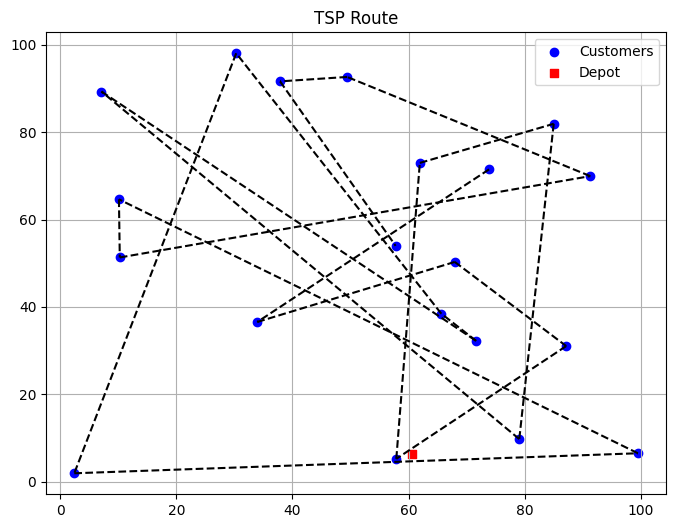

In [ ]:
import matplotlib.pyplot as plt

def evaluate_agent(env, agent):
    state = env.reset()
    done = False
    route = [env.current_idx]

    while not done:
        mask = torch.zeros(num_cust, dtype=torch.bool)
        mask[list(env.available)] = 1
        action, _, _ = agent.select_action(state, mask)
        state, _, done = env.step(action)
        route.append(env.current_idx)

    total_dist = env.get_total_distance()
    return route, total_dist

def plot_route(customers, depot, route, title="TSP Route"):
    plt.figure(figsize=(8, 6))
    x = customers[:, 0]
    y = customers[:, 1]
    plt.scatter(x, y, c='blue', label='Customers')
    plt.scatter(depot[0, 0], depot[0, 1], c='red', label='Depot', marker='s')

    # Plot route
    for i in range(len(route) - 1):
        start = customers[route[i]]
        end = customers[route[i + 1]]
        plt.plot([start[0], end[0]], [start[1], end[1]], 'k--')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Run evaluation and visualize
route, dist = evaluate_agent(env, agent)
print(f"🔎 Total tour distance: {dist:.2f}")
plot_route(env.customers, env.depot, route)


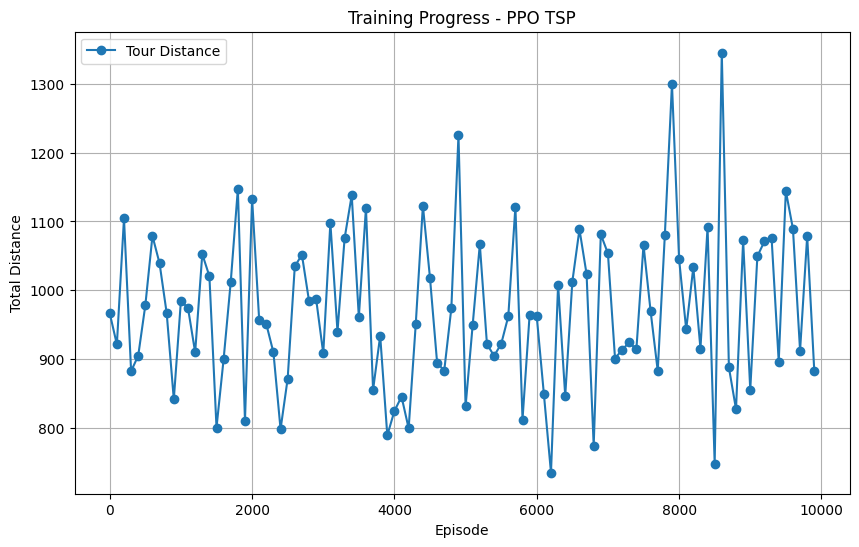

In [ ]:


import matplotlib.pyplot as plt

def plot_training_curve(returns_log, interval=100):
    episodes = list(range(0, len(returns_log) * interval, interval))
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, returns_log, marker='o', label='Tour Distance')
    plt.xlabel("Episode")
    plt.ylabel("Total Distance")
    plt.title("Training Progress - PPO TSP")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_training_curve(returns_log)


**Save model**

In [ ]:
def save_model(agent, path='ppo_tsp_model.pth'):
    torch.save({
        'actor': agent.actor.state_dict(),
        'critic': agent.critic.state_dict()
    }, path)
    print("Model saved!")

# 🔁 Load model
def load_model(agent, path='ppo_tsp_model.pth'):
    checkpoint = torch.load(path)
    agent.actor.load_state_dict(checkpoint['actor'])
    agent.critic.load_state_dict(checkpoint['critic'])
    print("Model loaded!")

# Example usage
save_model(agent)
# load_model(agent)  # Uncomment to reload model


Model saved!


** Random baseline comparison**


PPO Agent Distance: 982.45
Random Baseline Distance: 1048.96


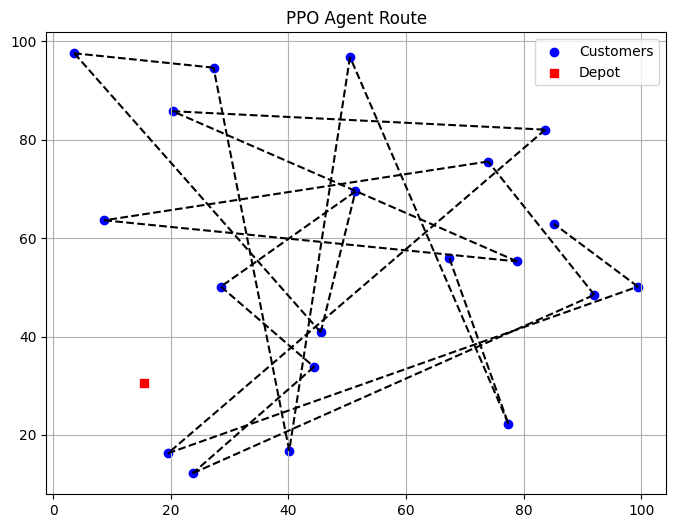

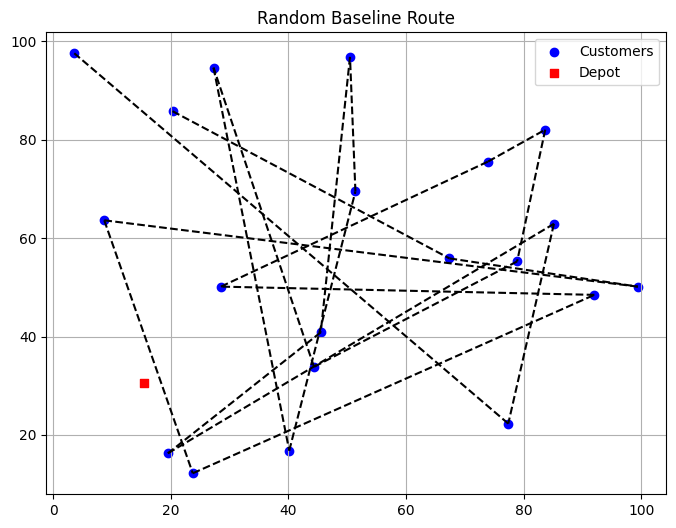

In [ ]:
def random_baseline(env):
    state = env.reset()
    done = False
    route = [env.current_idx]

    while not done:
        action = np.random.choice(list(env.available))
        state, _, done = env.step(action)
        route.append(env.current_idx)

    total_dist = env.get_total_distance()
    return route, total_dist

# Evaluate PPO agent
ppo_route, ppo_dist = evaluate_agent(env, agent)

# Evaluate random
rand_route, rand_dist = random_baseline(env)

# Results
print(f"\nPPO Agent Distance: {ppo_dist:.2f}")
print(f"Random Baseline Distance: {rand_dist:.2f}")

# Compare visually
plot_route(env.customers, env.depot, ppo_route, title="PPO Agent Route")
plot_route(env.customers, env.depot, rand_route, title="Random Baseline Route")
